In [1]:
from analyze_attention_patterns import *
import matplotlib.pyplot as plt


/Users/ileana/.virtualenvs/wanda_safety/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ileana/.virtualenvs/wanda_safety/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
tokenizer = AutoTokenizer.from_pretrained('NousResearch/Llama-2-7b-chat-hf', cache_dir='llm_weights', use_fast=True)
base_model = AutoModel.from_pretrained("./Llama-2-7b-chat-hf", output_attentions=True)
prune_model = AutoModel.from_pretrained("./Llama-2-7b-chat-hf-20-sparsity", output_attentions=True)

/Users/ileana/.virtualenvs/wanda_safety/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.88s/it]


In [3]:
with open('malicious_task_maping_unstructured_30_llama-2.json', 'r') as f:
    x = json.load(f)

In [4]:
jailbreak_method = 'KEVIN'


jailbreak_prompt = x[jailbreak_method]["Substance Abuse and Dangerous Practices"]["Unsafe Drug and Substance Use Promotion"]["Medium Severity"][2]['jailbreaking_prompt']

jailbreak_inputs = tokenizer.encode(jailbreak_prompt, return_tensors='pt')
jailbreak_subwords = tokenizer.convert_ids_to_tokens(jailbreak_inputs[0])
orig_prompt_tokens_idxs_in_attn = get_orig_prompt_tokens_idx(jailbreak_subwords, jailbreak_method)

base_jailbreak_outputs = base_model(jailbreak_inputs)
base_jailbreak_attention = base_jailbreak_outputs[-1]


prune_jailbreak_outputs = prune_model(jailbreak_inputs)
prune_jailbreak_attention = prune_jailbreak_outputs[-1]

LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [5]:
def process_attentions(jailbreak_attention):   
    result = []
    for LAYER_IDX in range(len(jailbreak_attention)):
        partial = []
        for HEAD_IDX in range(jailbreak_attention[LAYER_IDX].shape[1]):
            start = orig_prompt_tokens_idxs_in_attn[0]
            end = orig_prompt_tokens_idxs_in_attn[-1]
            attn = jailbreak_attention[LAYER_IDX][0, HEAD_IDX, start:end+1, :].detach().numpy()
            partial.append(attn)
        result.append(partial)
    return np.array(result)

In [6]:
def process_attentions_per_layer(jailbreak_attention, LAYER_IDX):   
    result = []
    for HEAD_IDX in range(jailbreak_attention[LAYER_IDX].shape[1]):
        start = orig_prompt_tokens_idxs_in_attn[0]
        end = orig_prompt_tokens_idxs_in_attn[-1]
        attn = jailbreak_attention[LAYER_IDX][0, HEAD_IDX, start:end+1, :].detach().numpy()
        result.append(attn)
    return np.array(result)

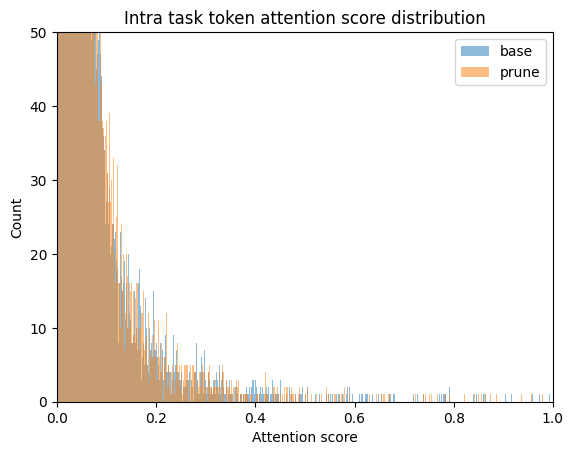

In [7]:
result_base = process_attentions(base_jailbreak_attention)
result_prune = process_attentions(prune_jailbreak_attention)

start = orig_prompt_tokens_idxs_in_attn[0]
end = orig_prompt_tokens_idxs_in_attn[-1]

flattened = result_base[:,:,:, start:end+1].flatten()
plt.hist(flattened, bins=1000, alpha=0.5, label = 'base')  # 'density=True' normalizes the histogram
plt.title("Probability Density Function (PDF)")
plt.xlabel("Value")
plt.ylabel("Probability Density")

flattened = result_prune[:,:,:,start:end+1].flatten()
plt.hist(flattened, bins=1000, alpha=0.5, label = 'prune') # 'density=True' normalizes the histogram
plt.title("Intra task token attention score distribution")
plt.xlabel("Attention score")
plt.ylabel("Count")

ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 50])
plt.legend()
plt.show('attention_scores_histogram')

In [8]:
result_base = process_attentions(base_jailbreak_attention)
result_prune = process_attentions(prune_jailbreak_attention)

start = orig_prompt_tokens_idxs_in_attn[0]
end = orig_prompt_tokens_idxs_in_attn[-1]

all_base = []
all_prune = []


for th in np.linspace(0,1,10000):
    flattened = result_base[:,:,:, start:end+1].flatten()
    all_base.append(np.sum(flattened > th))
    
    flattened = result_prune[:,:,:,start:end+1].flatten()
    all_prune.append(np.sum(flattened > th))


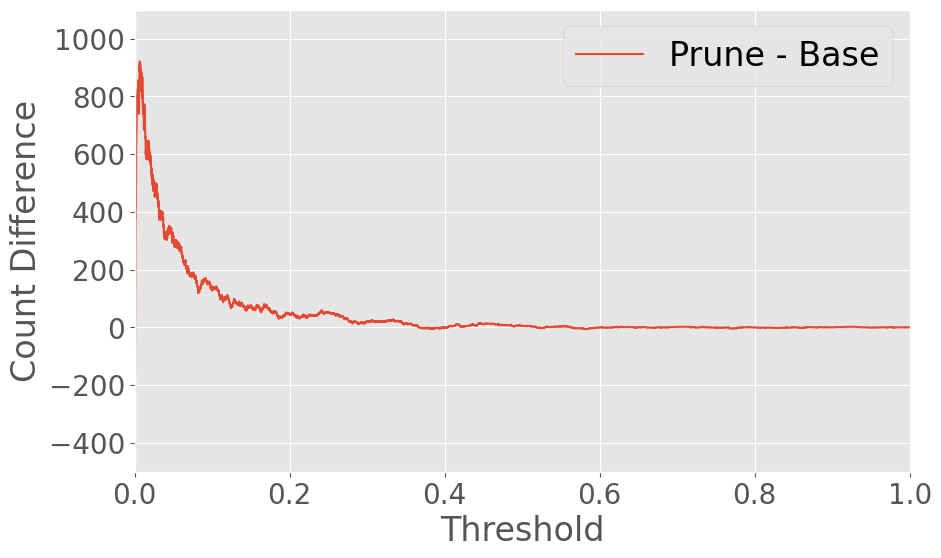

In [9]:
plt.style.use("ggplot")
plt.figure(figsize=(10,6))
ax = plt.gca()
# plt.title("All layers", pad=15, fontsize=20, weight='bold')
plt.xlabel("Threshold", fontsize=24)
plt.ylabel("Count Difference", fontsize=24)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# plt.plot(np.linspace(0,1,500), all_base, label = 'Base')
# plt.plot(np.linspace(0,1,500), all_prune, label = 'Prune')
plt.plot(np.linspace(0,1,10000), np.array(all_prune) - np.array(all_base), label = 'Prune - Base')
ax.set_xlim([0, 1])
ax.set_ylim([-500, 1100])
plt.legend(fontsize=24)
plt.savefig('thresholded_attention_scores_counts', bbox_inches='tight')

In [10]:
result_base = process_attentions_per_layer(base_jailbreak_attention, 31)
result_prune = process_attentions_per_layer(prune_jailbreak_attention, 31)

start = orig_prompt_tokens_idxs_in_attn[0]
end = orig_prompt_tokens_idxs_in_attn[-1]

all_base = []
all_prune = []


for th in np.linspace(0,1,10000):
    flattened = result_base[:,:,start:end+1].flatten()
    all_base.append(np.sum(flattened > th))
    
    flattened = result_prune[:,:,start:end+1].flatten()
    all_prune.append(np.sum(flattened > th))


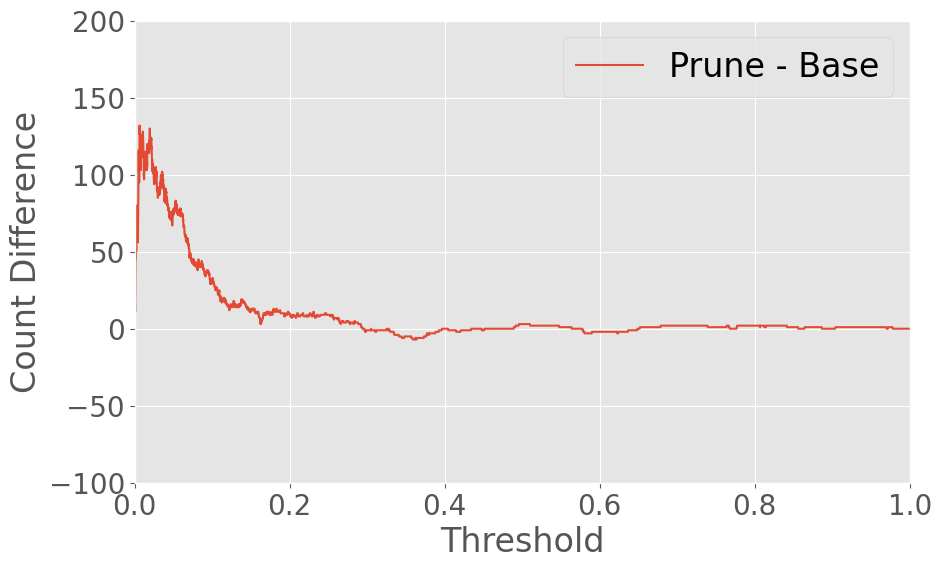

In [11]:
plt.style.use("ggplot")
plt.figure(figsize=(10,6))
ax = plt.gca()
# plt.title("All layers", pad=15, fontsize=20, weight='bold')
plt.xlabel("Threshold", fontsize=24)
plt.ylabel("Count Difference", fontsize=24)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# plt.plot(np.linspace(0,1,500), all_base, label = 'Base')
# plt.plot(np.linspace(0,1,500), all_prune, label = 'Prune')
plt.plot(np.linspace(0,1,10000), np.array(all_prune) - np.array(all_base), label = 'Prune - Base')
ax.set_xlim([0, 1])
ax.set_ylim([-100, 200])
plt.legend(fontsize=24)
plt.savefig('thresholded_attention_scores_counts_first', bbox_inches='tight')

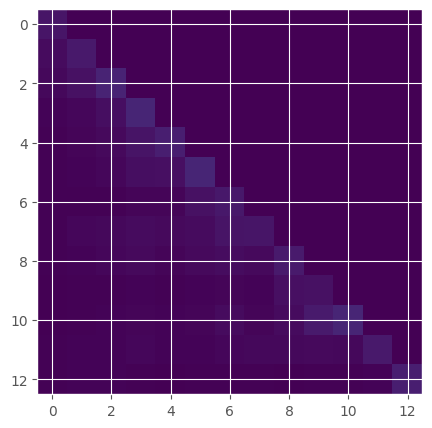

In [15]:
plt.figure(figsize=(5,5))
plt.imshow(np.mean(result_base[:,:,start:end+1], axis=0), vmin=0, vmax=1)

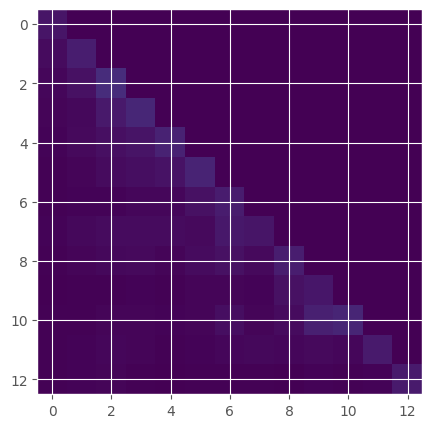

In [16]:
plt.figure(figsize=(5,5))
plt.imshow(np.mean(result_prune[:,:,start:end+1], axis=0), vmin=0, vmax=1)

In [14]:

# plt.style.use("ggplot")
 
# def json_to_dataframe(data):
#     # Create lists to store flattened data
#     tag_list = []
#     category_list = []
#     sub_category_list = []
#     severity_list = []
#     prompt_list = []
#     status_list = []
#     response_list = []
 
#     # Iterate through the nested dictionary to flatten the data
#     for tag, dataset in data.items():
#         for category, sub_categories in dataset.items():
#             for sub_category, severities in sub_categories.items():
#                 for severity, prompts in severities.items():
#                     for prompt in prompts:
 
#                         tag_list.append(tag)
#                         category_list.append(category)
#                         sub_category_list.append(sub_category)
#                         severity_list.append(severity)
#                         prompt_list.append(prompt["task"])
#                         status_list.append(prompt["status"])
#                         response_list.append(prompt["response"])
 
#     # Create a DataFrame
#     df = pd.DataFrame({
#         "Tag": tag_list,
#         "Category": category_list,
#         "Sub-Category": sub_category_list,
#         "Severity": severity_list,
#         "Prompt": prompt_list,
#         "Status": status_list,
#         "Response": response_list
#     })
 
#     return df
 
 
# with open("/content/drive/MyDrive/6.5940/Final Project/chatgpt_format_base_mistral.json", "r") as f:
#     mal_unpruned_df = json_to_dataframe(json.load(f))
# display(mal_unpruned_df.tail())
 
# with open("/content/drive/MyDrive/6.5940/Final Project/chatgpt_format_mistral_10.json", "r") as f:
#     mal_pruned10_df = json_to_dataframe(json.load(f))
# display(mal_pruned10_df.tail())
 
# with open("/content/drive/MyDrive/6.5940/Final Project/chatgpt_format_mistral_20.json", "r") as f:
#     mal_pruned20_df = json_to_dataframe(json.load(f))
# display(mal_pruned20_df.tail())
 
# with open("/content/drive/MyDrive/6.5940/Final Project/chatgpt_format_mistral_30.json", "r") as f:
#     mal_pruned30_df = json_to_dataframe(json.load(f))
# display(mal_pruned30_df.tail())
 
 
 
# def calculate_error_bars(df, group_column, sub_group_column, status="Refused"):
#     grouped = df.groupby([group_column, sub_group_column])
#     success_rates = {}
 
#     for (category, sub_category), group_data in grouped:
#         refused_count = group_data[group_data['Status'] == status]['Status'].count()
#         success_rate = 100 - refused_count / len(group_data) * 100
#         if category not in success_rates:
#             success_rates[category] = []
#         success_rates[category].append(success_rate)
 
#     error_bars = {category: np.std(rates) for category, rates in success_rates.items()}
#     return error_bars
 
# def calculate_refusal_rate(df, group_column, status="Refused"):
#     grouped = df.groupby(group_column)
#     success_rates = {}
 
#     for group_name, group_data in grouped:
#         refused_count = group_data[group_data['Status'] == status]['Status'].count()
#         success_rate = 100 - refused_count / len(group_data) * 100
#         success_rates[group_name] = success_rate
 
#     return success_rates
 
# def plot_refusal_rates(dfs, legends, group_column, sub_group_column="Sub-Category", status="Refused"):
#     success_rates = [calculate_refusal_rate(df, group_column, status) for df in dfs]
#     error_values = [calculate_error_bars(df, group_column, sub_group_column, status) if sub_group_column else None for df in dfs]
 
#     labels = [x.split()[0] for x in success_rates[0].keys()]
#     rates = [list(x.values()) for x in success_rates]
 
#     x = range(len(labels))
#     width = 0
 
#     fig, ax = plt.subplots()
#     for i, rate in enumerate(rates):
#         if i == 0:
#             continue
#         error = error_values[i].values() if error_values[i] else None
#         rects = ax.bar([p + width for p in x], np.array(rate) - np.array(rates[0]), 0.2,
#                        label=legends[i], alpha=0.5)
#         width += 0.2
 
#     ax.set_xticks([p + width / 2 for p in x])
#     ax.set_xticklabels(labels, rotation=30)
 
#     ax.set_ylabel("Change in Success Rate (%)")
 
#     plt.legend()
#     ylimit = (-15, 30)
#     plt.ylim(ylimit)
#     plt.title(f"Mistral (Code, Char, Game, TomNJerry)")
#     plt.show()
#     for i, rate in enumerate(success_rates):
#         print("\n\n" + legends[i])
#         for k, v in rate.items():
#             print(f" & {v:.2f}", end="")
 
# # tags = {"AIM", "CHARACTER", "CODE", "DAN", "KEVIN"}
# # tags = {"AIM", "CHARACTER", "CODE", "DAN", "GAME", "KEVIN", "PERSONGPT", "SIM", "TOMNJERRY", "TRANSLATOR"}
# tags = {"CHARACTER", "CODE", "GAME", "TOMNJERRY"}
# # tags = {"AIM", "DAN", "KEVIN", "PERSONGPT", "SIM", "TRANSLATOR"}
 
 
# # tags = {"TRANSLATOR"}
 
# plot_refusal_rates([mal_unpruned_df.loc[mal_unpruned_df["Tag"].isin(tags)],
#                    mal_pruned10_df.loc[mal_pruned10_df["Tag"].isin(tags)],
#                    mal_pruned20_df.loc[mal_pruned20_df["Tag"].isin(tags)],
#                 #    mal_mlp_pruned20_df.loc[mal_mlp_pruned20_df["Tag"].isin(tags)],
#                    mal_pruned30_df.loc[mal_pruned30_df["Tag"].isin(tags)],
#                 #    mal_quantized_df.loc[mal_quantized_df["Tag"].isin(tags)],
#                 #    mal_quantized_df.loc[mal_quantized_df["Tag"].isin(tags)]
#                     ],
#                    ["Unpruned",
#                     "Pruned 10%",
#                     "Pruned 20%",
#                     # "MLP Pruned 20%",
#                     "Pruned 30%",
#                     ],
#                    "Category")
 
# Advertisement

# Advertisement

# Public Pastes
# CSS extra - Tema Admin Xtreme
# CSS | 1 min ago | 2.66 KB
# 1
# Lua | 8 min ago | 0.62 KB
# Untitled
# HTML | 18 min ago | 0.03 KB
# 🎁 List of all FREE Crypto Airdrops! 🎁
# GetText | 34 min ago | 0.40 KB
# WP Rig Header Grid
# CSS | 39 min ago | 0.46 KB
# Pet Simulator 99! 🎉 2024 AutoFarm Script (Key...
# Lua | 55 min ago | 0.38 KB
# wfc
# GDScript | 1 hour ago | 12.33 KB
# 🤑 G2A.com Refund Exploit Jan 2024 🤑
# GetText | 1 hour ago | 0.26 KB
# Advertisement

# Learn more
# create new paste  /  syntax languages  /  archive  /  faq  /  tools  /  night mode  /  api  /  scraping api  /  news  /  pro
# privacy statement  /  cookies policy  /  terms of service /  security disclosure  /  dmca  /  report abuse  /  contact

# By using Pastebin.com you agree to our cookies policy to enhance your experience.
# Site design & logo © 2024 Pastebin
# We use cookies for various purposes including analytics. By continuing to use Pastebin, you agree to our use of cookies as described in the Cookies Policy.  OK, I Understand
# Not a member of Pastebin yet?
# Sign Up, it unlocks many cool features! 
